## Assignment 2: Adversarial Training

This assignment requires you to create adversarial examples. You will do adversarial training, i.e., train the model with sets of adversarial examples you generated and evaluate the performances of the model on test sets.

### What is Adversarial Training?
Adversarial training is a machine learning technique to improve models' robustness by training them on adversarial examples. Adversarial examples are input data that has been intentionally modified to cause the model to misclassify or produce an incorrect output.

When a model is trained using adversarial examples, it becomes more resilient to adversarial attacks and is able to better identify and classify input data that may have been modified or corrupted. This may lead to improved performance of the model in real-world scenarios where the input data may not always be perfect.

However, adversarial training can also have some negative impacts on ML models. For example, it can lead to overfitting, where the model becomes too specialized to the particular adversarial examples used in training and is unable to generalize well to new examples. Additionally, adversarial training can increase the computational requirements of training the model due to the need for generating adversarial examples.

Overall, while adversarial training can improve the robustness of ML models, it is important to carefully consider its potential benefits and drawbacks and to evaluate the trade-offs in terms of model performance and computational requirements. The following are the steps involved in adversarial training:

1. Generate adversarial examples: In the first step, we generate adversarial examples by perturbing the original data points in such a way that the modifications are small and not noticeable to humans but are enough to cause misclassification by the neural network.

2. Train on adversarial examples: In the second step, we train the neural network on adversarial examples in addition to the original training data. This helps to improve the network's ability to recognize and classify adversarial examples correctly.

3. Evaluate performance: In the third step, we evaluate the performance of the network on both the original and adversarial test data. This helps to determine if the adversarial training has improved the network's robustness against adversarial attacks.

Overall, adversarial training is a powerful technique that can help improve the security and reliability of deep neural networks.

In this Homework, you will run different adversarial training algorithms on the ResNet18 model with the adversarial examples, and evaluating the model performances on test data. The goal is to get experience in generating adversarial examples and train the model with these examples, i.e., adversarial training.

We have provided the model architecture ($\texttt{model.py}$) and some pre-defined functions ($\texttt{utils.py}$) so you can import and use them directly in the notebook.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import os
os.environ["CUDA_VISIBLE_DEVICE"]='0,1'
import numpy as np
from model import ResNet18
from utils import trades_loss, mixup_data, mixup_criterion, make_dataloader, eval_test

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Q1 (20 points)
Use the following parameters to define the LinfPGDAttack():

- Epsilon: 8/255
- PGD Steps: 10
- PGD Step Size: 0.003

In [2]:
class LinfPGDAttack(nn.Module):
    def __init__(self, model, epsilon, steps=10, step_size=0.003):
        super().__init__()
        self.model = model
        self.epsilon = epsilon
        self.steps = steps
        self.step_size = step_size

    def perturb(self, x_natural, y):
        """
        Computes the gradient of the cross-entropy loss with respect to the input
        image `x_adv` and updates the image based on the gradient direction. The
        perturbation is clipped to ensure it stays within a specified epsilon range
        and is finally clamped to ensure pixel values are valid.

        The resulting perturbed image is returned.
        """
        # *********** Your code starts here ***********

        # Initialize x_adv as detached copy of the input image
        x_adv = x_natural.detach()

        # Run perturbation steps
        for i in range(self.steps):
            # Enable gradient computation
            x_adv.requires_grad_()
            # Calculate model's logits and cross-entropy loss
            with torch.enable_grad():
                logits = self.model(x_adv)
                loss = F.cross_entropy(logits, y)

            # Compute the gradient of the loss with respect to x_adv
            grad = torch.autograd.grad(loss, [x_adv])[0]

            # Detach x_adv and add with alpha * torch.sign(grad.detach())
            x_adv = x_adv.detach() + self.step_size * torch.sign(grad.detach())
            # Take min(max(x_adv, x_natural-epsilon), x_natural+epsilon)
            x_adv = torch.min(torch.max(x_adv, x_natural - self.epsilon), x_natural + self.epsilon)
            # Clamp x_adv between 0, 1
            x_adv = torch.clamp(x_adv, 0, 1)

        # *********** Your code ends here *************

        return x_adv

    def forward(self, x_natural, y):
        x_adv = self.perturb(x_natural, y)
        return x_adv

There are many implementations of adversarial training; in this assignment, we ask you to evalaute which training algorithm can make the model more robust to LinfPGDAttack().

In [3]:
def train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        if mode == 'natural':
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train': # [Ref] https://arxiv.org/abs/1706.06083
            model.eval()
            adv_x = pgd_attack(inputs, targets)
            model.train()

            optimizer.zero_grad()
            outputs = model(adv_x)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train_trades': # [Ref] https://arxiv.org/abs/1901.08573
            optimizer.zero_grad()
            loss = trades_loss(model=model, x_natural=inputs, y=targets, optimizer=optimizer)

        elif mode == 'adv_train_mixup': # [Ref] https://arxiv.org/abs/1710.09412
            model.eval()
            benign_inputs, benign_targets_a, benign_targets_b, benign_lam = mixup_data(inputs, targets)
            adv_x = pgd_attack(inputs, targets)
            adv_inputs, adv_targets_a, adv_targets_b, adv_lam = mixup_data(adv_x, targets)

            model.train()
            optimizer.zero_grad()

            benign_outputs = model(benign_inputs)
            adv_outputs = model(adv_inputs)
            loss_1 = mixup_criterion(criterion, benign_outputs, benign_targets_a, benign_targets_b, benign_lam)
            loss_2 = mixup_criterion(criterion, adv_outputs, adv_targets_a, adv_targets_b, adv_lam)

            loss = (loss_1 + loss_2) / 2

        else:
            print("No training mode specified.")
            raise ValueError()

        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(inputs), len(train_loader) * batch_size,
                       100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [4]:
def train(model, train_loader, val_loader, pgd_attack,
          mode='natural', epochs=25, batch_size=256, learning_rate=0.1, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model1.pt'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    best_acc = 0
    for epoch in range(epochs):
        # training
        train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size)

        # evaluate clean accuracy
        test_loss, test_acc = eval_test(model, val_loader, device)

        # remember best acc@1 and save checkpoint
        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)

        # save checkpoint if is a new best
        if is_best:
            torch.save(model.state_dict(), checkpoint_path)
        print('================================================================')

### Q2 (40 points)
Use the four training modes ("natural", "adv_train", "adv_train_trades", and "adv_train_mixup") to obtain four models, and save them as $\texttt{model1.pt}$, $\texttt{model2.pt}$, $\texttt{model3.pt}$, and $\texttt{model4.pt}$, respectively.

When calculating your losses, you may encounter Nan. In this case, you may consider adjusting the `learning rate` to solve the problem.

In [5]:
# define parameters
batch_size = 256
data_path = "../data" # directory of the data
epsilon = 8/255
steps = 10
epochs = 10

# create data loader
train_loader, val_loader = make_dataloader(data_path, batch_size)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
training_mode = "natural"

# Define Model and Launch Training (Define Adversary If You Need It)

# Write your code here
model1 = ResNet18()
model1.cuda()

train(model=model1, train_loader=train_loader, val_loader=val_loader, pgd_attack=None, mode=training_mode, epochs=epochs,
      batch_size=batch_size, checkpoint_path='model1.pt')

Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.390481
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 1.889086
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 1.798849
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 1.775160
Test: Average loss: 0.0094, Accuracy: 2815/10000 (28%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 1.528354
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.561005
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.354891
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.318767
Test: Average loss: 0.0061, Accuracy: 4560/10000 (46%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.295948
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.262440
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.093580
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 1.197920
Test: Average loss: 0.0048, Accuracy: 5790/10000 (58%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.005721
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 0.990936
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 0.930154
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 0.959672
Test: Average loss: 0.0

In [13]:
training_mode = "adv_train"

# Define Model and Launch Training (Define Adversary If You Need It)
# Write your code here
model2 = ResNet18()
model2.cuda()
model2 = torch.nn.DataParallel(model2, device_ids=[0, 1])
pgd_attack = LinfPGDAttack(model2, epsilon=epsilon)
train(model=model2, train_loader=train_loader, val_loader=val_loader, pgd_attack=pgd_attack, mode=training_mode, epochs=epochs,
      batch_size=batch_size, checkpoint_path='model2.pt')

Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.482827
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 2.164833
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 2.192258
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 2.154127
Test: Average loss: 0.0074, Accuracy: 3155/10000 (32%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 2.079515
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 2.123087
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 2.044430
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.973585
Test: Average loss: 0.0069, Accuracy: 3643/10000 (36%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.980543
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.991829
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.963872
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 1.911904
Test: Average loss: 0.0063, Accuracy: 4301/10000 (43%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.922975
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.904783
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.765823
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.905377
Test: Average loss: 0.0

In [14]:
training_mode = "adv_train_trades"

# Define Model and Launch Training (Define Adversary If You Need It)
# Write your code here
model3 = ResNet18()
model3.cuda()
pgd_attack = LinfPGDAttack(model3, epsilon=epsilon)
train(model=model3, train_loader=train_loader, val_loader=val_loader, pgd_attack=pgd_attack, mode=training_mode, epochs=epochs,
      batch_size=batch_size, learning_rate=0.05, checkpoint_path='model3.pt')


/home/ivory/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.445592
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 1.838072
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 1.707909
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 1.697437
Test: Average loss: 0.0057, Accuracy: 4790/10000 (48%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 1.518470
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.530750
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.463001
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.451741
Test: Average loss: 0.0050, Accuracy: 5488/10000 (55%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.336166
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.461228
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.207500
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 1.274471
Test: Average loss: 0.0045, Accuracy: 6171/10000 (62%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.304280
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.284446
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.278777
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.245702
Test: Average loss: 0.0

In [6]:
training_mode = "adv_train_mixup"

# Define Model and Launch Training (Define Adversary If You Need It)
# Write your code here
model4 = ResNet18()
model4.cuda()
pgd_attack = LinfPGDAttack(model4, epsilon=epsilon)
train(model=model4, train_loader=train_loader, val_loader=val_loader, pgd_attack=pgd_attack, mode=training_mode, epochs=epochs,
      batch_size=batch_size, checkpoint_path='model4.pt')


Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.405887
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 2.150466
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 2.191463
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 2.155303
Test: Average loss: 0.0079, Accuracy: 3236/10000 (32%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 2.038793
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 2.048707
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 2.077245
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.953407
Test: Average loss: 0.0068, Accuracy: 3851/10000 (39%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.981774
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 2.006834
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 2.049617
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 2.017361
Test: Average loss: 0.0064, Accuracy: 4451/10000 (45%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 2.068131
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.972425
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.958564
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.965428
Test: Average loss: 0.0

### Q3 (20 points)
Use eval_robust() to evaluate each model's robustness against LinfPGDAttack().

In [18]:
from utils import eval_robust
# *********** Your code starts here ***********
model1 = ResNet18()
model1.cuda()
model1.load_state_dict(torch.load('model1.pt'))
pgd_attack.model = model1
robust_loss, robust_acc = eval_robust(model1, val_loader, pgd_attack, device)


# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0515, Robust Accuracy: 15/10000 (0%)


In [19]:
# *********** Your code starts here ***********
model2 = ResNet18()
checkpoint = torch.load('model2.pt')
checkpoint = {key[7:]: val for key, val in checkpoint.items()}
model2.load_state_dict(checkpoint)
model2.cuda()
pgd_attack.model = model2
robust_loss, robust_acc = eval_robust(model2, val_loader, pgd_attack, device)


# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0067, Robust Accuracy: 3590/10000 (36%)


In [20]:
# *********** Your code starts here ***********
model3 = ResNet18()
model3.cuda()
model3.load_state_dict(torch.load('model3.pt'))
pgd_attack.model = model3
robust_loss, robust_acc = eval_robust(model3, val_loader, pgd_attack, device)


# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0071, Robust Accuracy: 3350/10000 (34%)


In [21]:
# *********** Your code starts here ***********
model4 = ResNet18()
model4.cuda()
model4.load_state_dict(torch.load('model4.pt'))
pgd_attack.model = model4
robust_loss, robust_acc = eval_robust(model4, val_loader, pgd_attack, device)


# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0075, Robust Accuracy: 2837/10000 (28%)


### Q4 (10 points)
Visualize 10 adversarial examples from (with ground truth labels and model's predictions) from the model having best robust accuarcy.

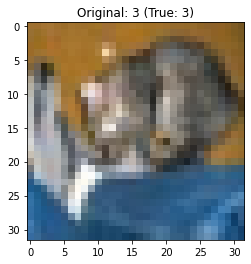

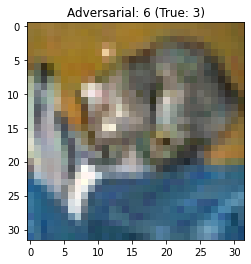

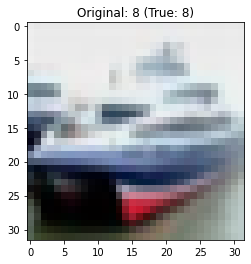

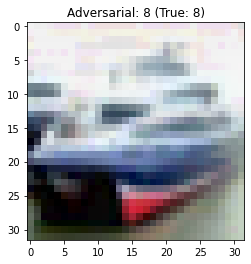

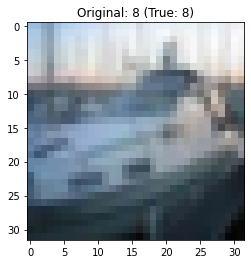

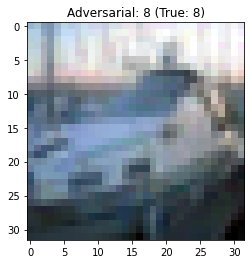

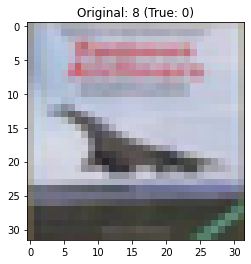

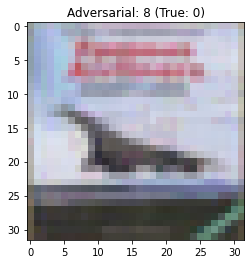

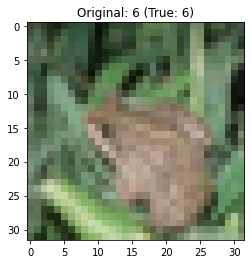

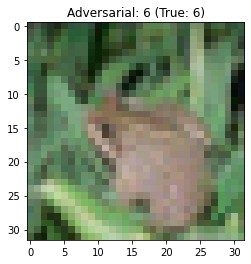

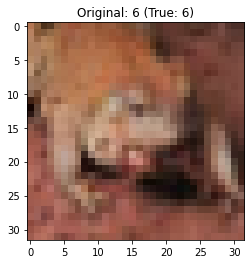

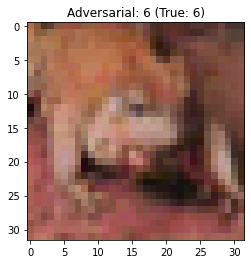

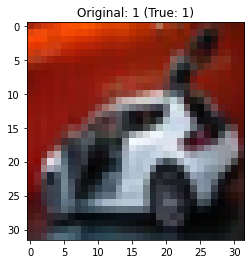

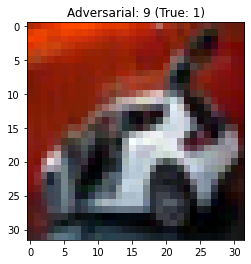

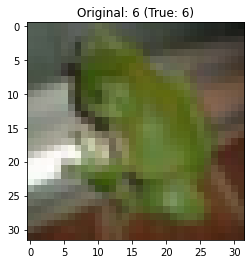

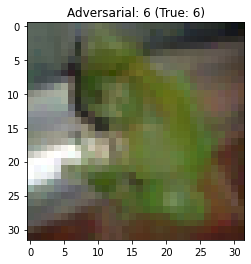

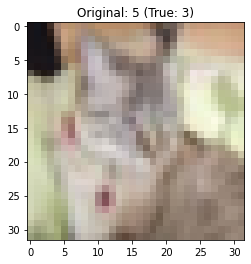

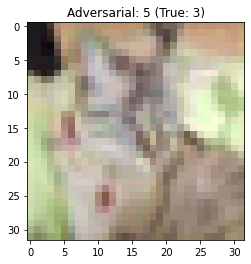

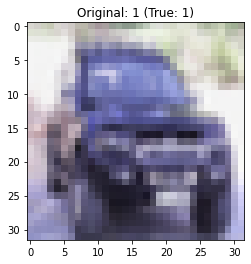

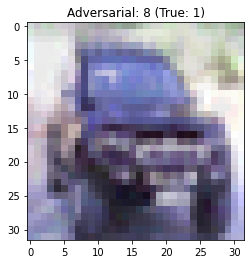

In [28]:
# *********** Your code starts here ***********
import matplotlib.pyplot as plt
def imshow(img, title):
    # img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def visualize_adversarial_examples(model, device, val_loader, pgd_attack, num_examples=10):
    model.eval()

    dataiter = iter(val_loader)
    images, labels = next(dataiter)

    # Move images and labels to the device
    images, labels = images.to(device), labels.to(device)

    # Original predictions
    outputs_original = model(images)
    _, predicted_original = torch.max(outputs_original, 1)

    # Generate adversarial examples
    adversarial_images = pgd_attack(images, labels)

    # Adversarial predictions
    outputs_adversarial = model(adversarial_images)
    _, predicted_adversarial = torch.max(outputs_adversarial, 1)

    # Visualize examples
    for i in range(num_examples):
        imshow(images[i] .cpu(), f'Original: {predicted_original[i]} (True: {labels[i]})')
        imshow(adversarial_images[i].cpu(), f'Adversarial: {predicted_adversarial[i]} (True: {labels[i]})')

pgd_attack.model = model2
visualize_adversarial_examples(model2, device, val_loader, pgd_attack)

# *********** Your code ends here *************

### Q5 (10 points)
Which adversarial training algorithm achieves the best robust accuracy in only 25 training epochs? Why do you think that adversarial training algorithm outperforms others? Do you encounter any difficulties when you implement this assignment?

*Write your answer here.*

Model 2, the adv_train method works best. The adv_train algorithm excels due to the efficacy of the adversarial training approach without additional techniques such as TRADES or mixup. The adv_train method focuses on fortifying the model against adversarial attacks by exposing it to perturbed training examples. This is a simple method; without the complexity of additional regularization techniques and data augmentation, and allows for a more effective and robust learning process. The results prove the importance of a streamlined adversarial training approach - a straightforward strategy yields the most favorable performance outcome.

When I was implementing this assignment, I encountered some difficulty with the long runtime, and had to switch to using a gpu to speed up the training process.


## Submission Instructions

Please submit this  to Canvas, as well as results, as per instructions.
Please compress `First_Middle_Last_HW1/` into one zip file with the name `First_Middle_Last_HW1.zip` before uploading it to Canvas. The directory contains your notebook and four model checkpoints. As listed below:

- $\texttt{Assignment_2.ipynb}$: your code
- $\texttt{model1.pt}$: your model checkpoint with *natural training*
- $\texttt{model2.pt}$: your model checkpoint with *adv_train* training
- $\texttt{model3.pt}$: your model checkpoint with *adv_train_trades* training
- $\texttt{model4.pt}$: your model checkpoint with *adv_train_mixup* training

## Academic Integrity

This homework assignment must be done individually. Sharing code or model specifications is strictly prohibited. Homework discussions are allowed only on Piazza, according to the policy outlined on the course web page: [https://canvas.dartmouth.edu/courses/63219](https://canvas.dartmouth.edu/courses/63219). You are not allowed to search online for auxiliary software, reference models, architecture specifications, or additional data to solve the homework assignment. Your submission must be entirely your own work. That is, the code and the answers that you submit must be created, typed, and documented by you alone, based exclusively on the materials discussed in class, and released with the homework assignment. You can obviously consult the class slides posted in Canvas, your lecture notes, and the textbook. Important: the models you will submit for this homework assignment must be
trained exclusively on the specified data provided with this assignment. You can, of course, play with other datasets in your spare time. These rules will be strictly enforced, and any violation will be treated seriously.